Assignment: To run regular regression, lasso regression, and ridge regression against 2017 Texas crime dataset and compare the performance of the 3 models, and improve the performance of the models without overfitting.  

Due to the high variance (primarily because of having large urban centers in the save dataset as small rural towns) most features needed to be log transformed. 

I created a several new boolean features (Highhomicide, Highaggassault, Highcrime) based on FBI crimerate data, if the value was higher than the average crimerate for that catagory it gave a value of "1" (above national average), if it was the same as or lower the value was 0.  I also created several boolean features based on population (under 10k, under 100k, over 100k). Boolean values were also created for all existing features after removing features that had a correllation of higher than 90%.


I chose "Highcrime" as my "y" value since it was an aggregate of all the crime data.  The question I was attempting to answer: is a given city's crime rate above the national average?

Initial runs of this data produced the following results:

Plain Regression:  An accuracy score of 75%, but after removing several of the added boolean features this moved up to 82%, removing all of the boolean features (except for the "y" value) I raised the accuracy score up to 98%.

Ridge Regression: With the original first run data mentioned above (all boolean values) most cross validation scores were below 40%, but after removing unneeded features I was able to achieve cross validation scores above 40%.  However, after removing all boolean features (except for the "y" value) all cross validation scores went up by a value of 10.

Lasso Regression: With the original first run data mentioned above (all boolean values) most cross validation scores were below 40%, but after removing unneeded features I was able to achieve cross validation scores above 40%.  However, after removing all boolean features (except for the "y" value) all cross validation scores went up by a value of 10.

It is my conclusion that this data was more suited for plain logistical regression, why? I am uncertain.



In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import scipy
from scipy.stats import spearmanr
from pylab import rcParams
import seaborn as sb
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
%matplotlib inline
sns.set_style('white')

crimedata = pd.read_csv('texas2017crime.csv')

crimedata.rename(columns={'State' : 'City', 'Murder and\nnonnegligent\nmanslaughter': 'Homicide', 'Violent\ncrime' : 'Violent crime',
                         'Aggravated\nassault' : 'Aggravated assault','Motor\nvehicle\ntheft' :  'Vehicle theft',
                         'Larceny-\ntheft' : 'Theft', 'Property\ncrime' : 'Property crime' }, inplace = True)



In [2]:
features = list(crimedata.columns)
features.pop(0)

'City'

In [3]:
crimedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 12 columns):
City                  613 non-null object
Population            613 non-null object
Violent crime         613 non-null object
Homicide              613 non-null int64
Rape1                 613 non-null object
Robbery               613 non-null object
Aggravated assault    613 non-null object
Property crime        610 non-null object
Burglary              610 non-null object
Theft                 613 non-null object
Vehicle theft         613 non-null object
Arson                 613 non-null int64
dtypes: int64(2), object(10)
memory usage: 57.5+ KB


In [4]:
crimedata['Population'] = crimedata['Population'].replace({',':''}, regex=True)
#crimedata['Homicide'] = crimedata['Homicide'].replace({',':''}, regex=True)
crimedata['Aggravated assault'] = crimedata['Aggravated assault'].replace({',':''}, regex=True)
crimedata['Violent crime'] = crimedata['Violent crime'].replace({',':''}, regex=True)
crimedata['Vehicle theft'] = crimedata['Vehicle theft'].replace({',':''}, regex=True)
crimedata['Theft'] = crimedata['Theft'].replace({',':''}, regex=True)
crimedata['Property crime'] = crimedata['Property crime'].replace({',':''}, regex=True)
crimedata['Rape1'] = crimedata['Rape1'].replace({',':''}, regex=True)
crimedata['Robbery'] = crimedata['Robbery'].replace({',':''}, regex=True)
crimedata['Burglary'] = crimedata['Burglary'].replace({',':''}, regex=True)





In [5]:
crimedata['Population'] = crimedata['Population'].astype('int64')
crimedata['Property crime'] = crimedata['Property crime'].astype('float64')
crimedata['Burglary'] = crimedata['Burglary'].astype('float64')
crimedata['Theft'] = crimedata['Theft'].astype('float64')
crimedata['Vehicle theft'] = crimedata['Vehicle theft'].astype('int64')
crimedata['Arson'] = crimedata['Arson'].astype('int64')
crimedata['Rape1'] = crimedata['Rape1'].astype('int64')
crimedata['Robbery'] = crimedata['Robbery'].astype('int64')
crimedata['Aggravated assault'] = crimedata['Aggravated assault'].astype('int64')
crimedata['Violent crime'] = crimedata['Violent crime'].astype('int64')



In [6]:
crimedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 12 columns):
City                  613 non-null object
Population            613 non-null int64
Violent crime         613 non-null int64
Homicide              613 non-null int64
Rape1                 613 non-null int64
Robbery               613 non-null int64
Aggravated assault    613 non-null int64
Property crime        610 non-null float64
Burglary              610 non-null float64
Theft                 613 non-null float64
Vehicle theft         613 non-null int64
Arson                 613 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 57.5+ KB


In [7]:
crimedata.head()

,City,Population,Violent crime,Homicide,Rape1,Robbery,Aggravated assault,Property crime,Burglary,Theft,Vehicle theft,Arson
0,Abernathy,2756,8,0,0,0,8,27.0,3.0,16.0,8,0
1,"Abilene2, 3",122981,636,4,100,138,394,2566.0,244.0,2605.0,260,20
2,Addison,15795,95,0,22,16,57,773.0,111.0,565.0,97,5
3,Alamo,19351,178,0,15,20,143,946.0,124.0,771.0,51,2
4,Alamo Heights,8507,14,0,0,1,13,182.0,25.0,152.0,5,0


In [8]:
crimedata[features] = crimedata[features].replace(np.nan, 0)

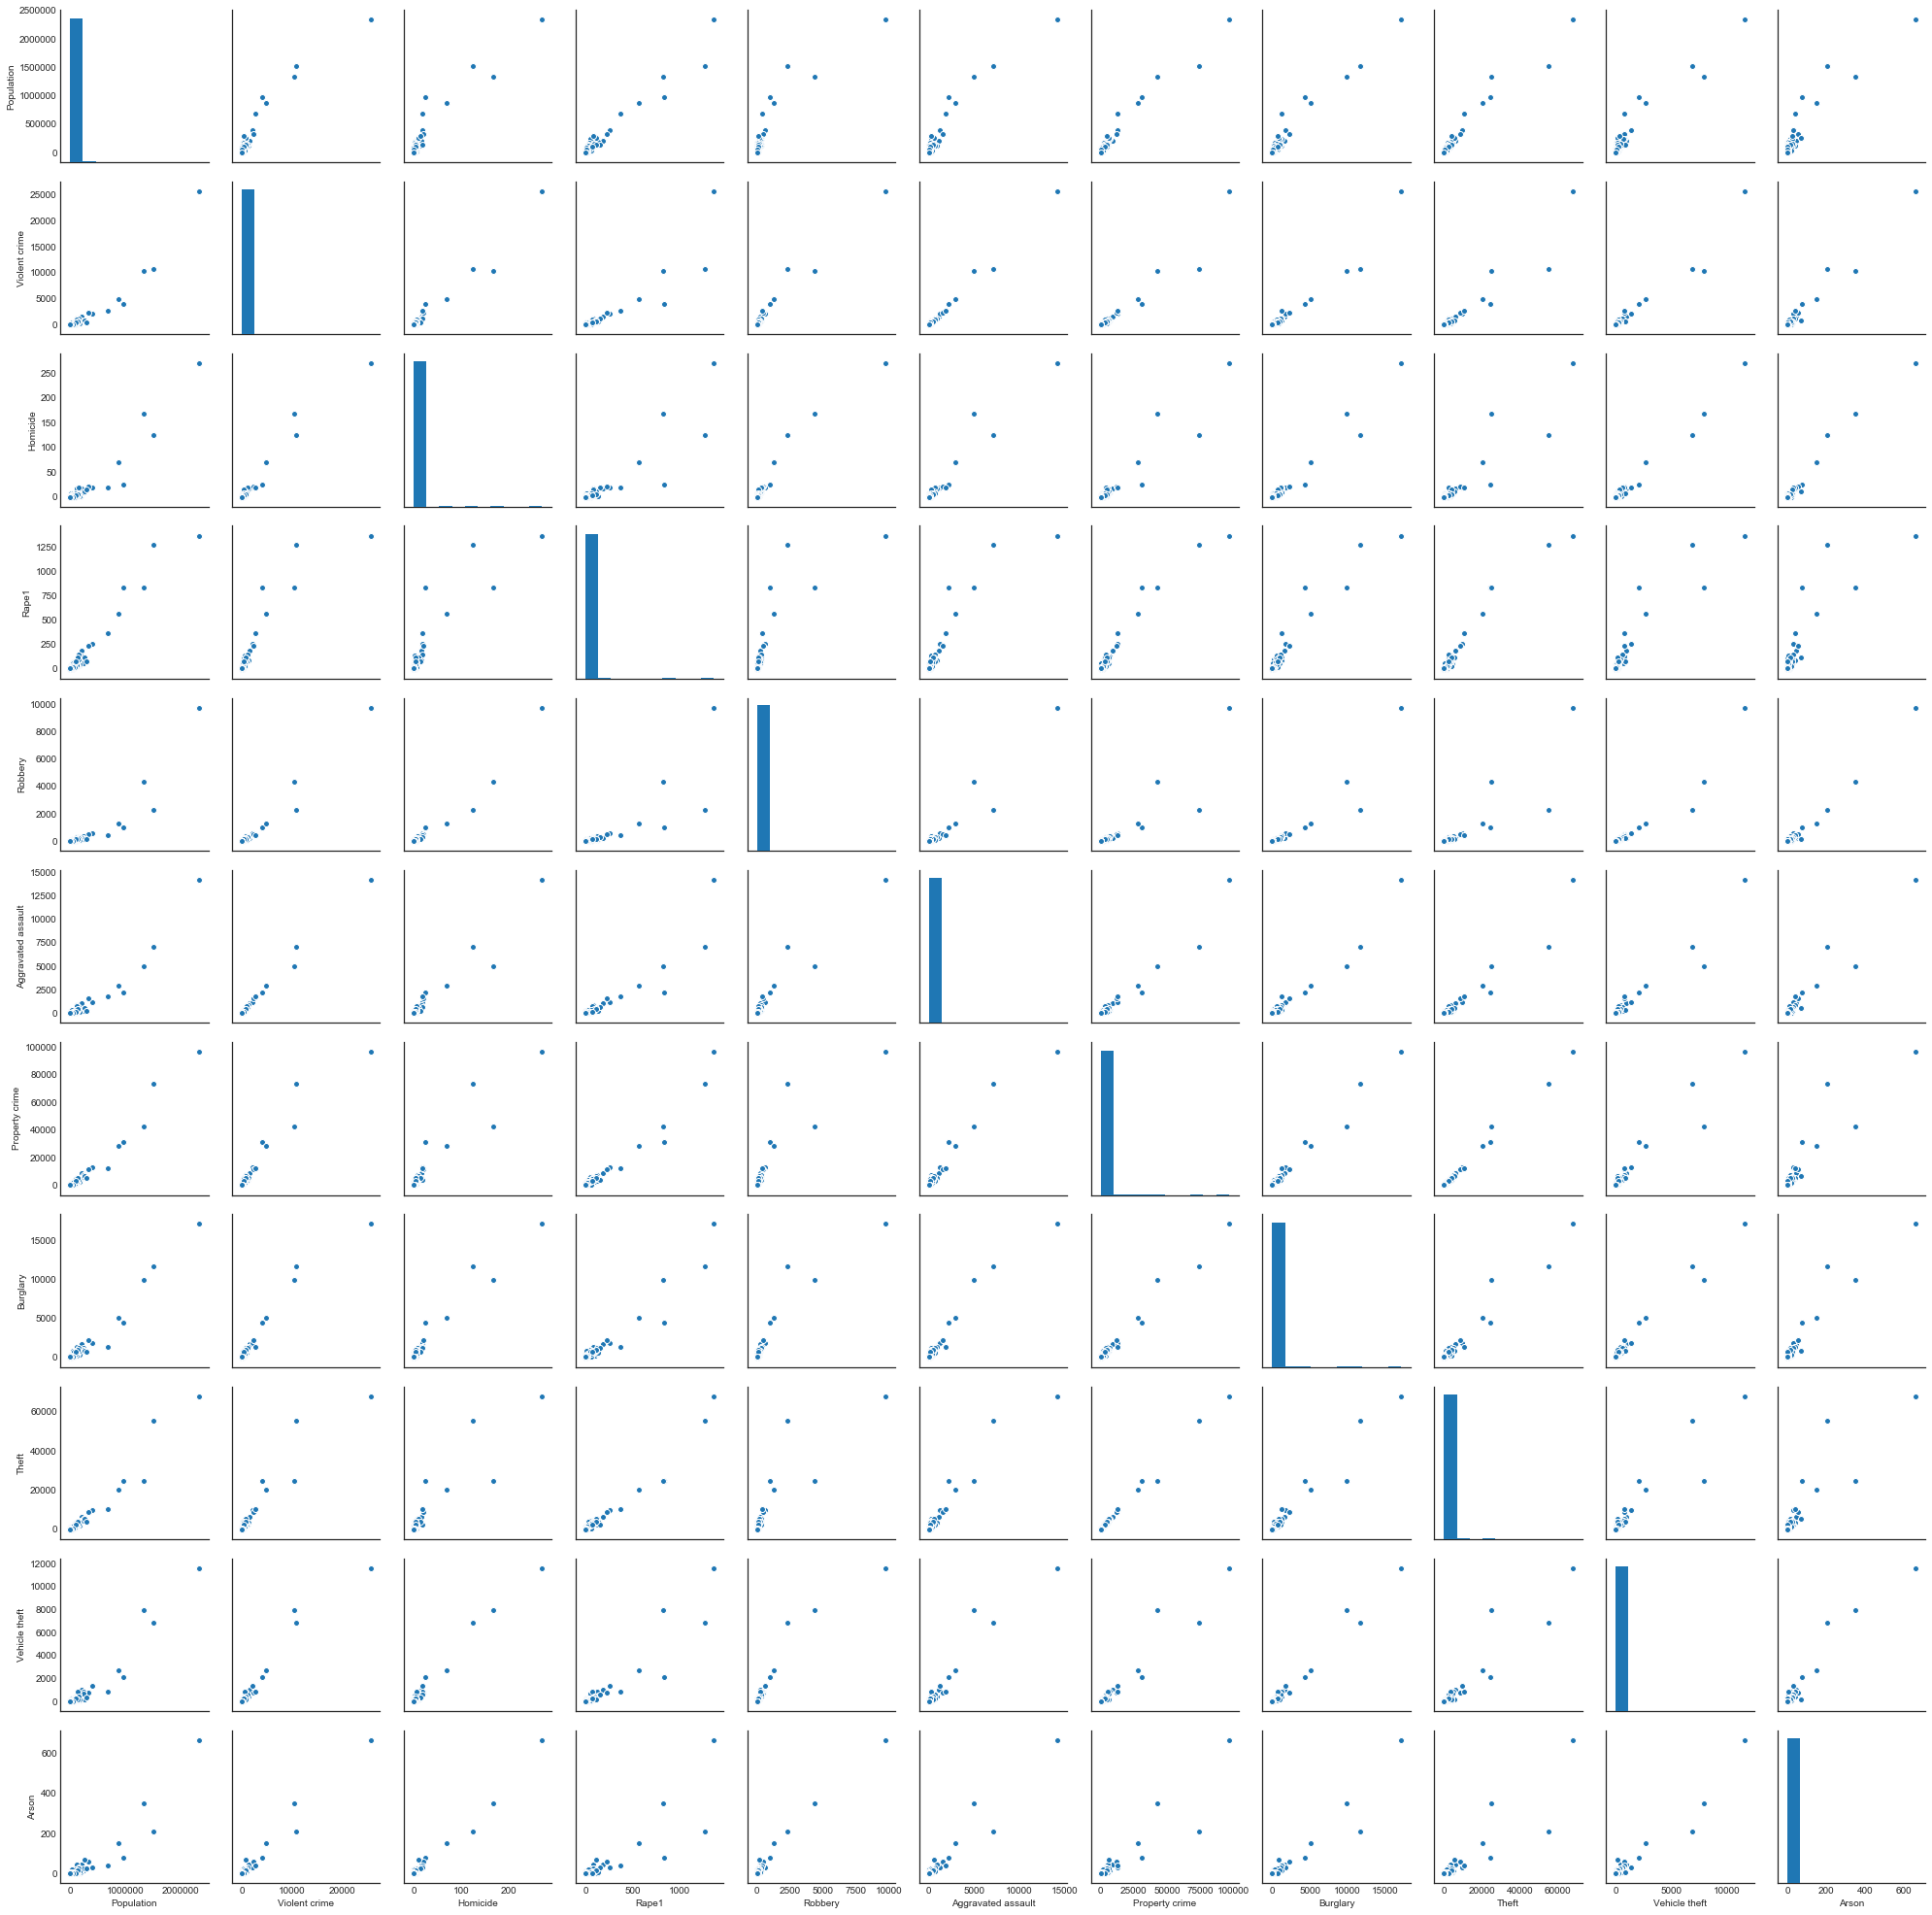

In [9]:
sns.pairplot(crimedata[features])

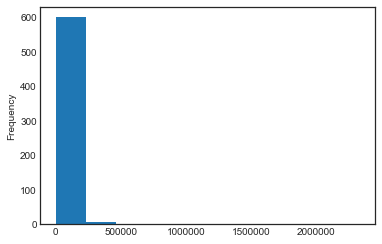

In [10]:
crimedata['Population'].plot.hist()
plt.show()

In [11]:
#crimedata.Population = np.log(crimedata.Population)
#np.log(crimedata['Violent crime'])
crimedata['Pop10korless'] = pd.Series(np.where(crimedata.Population < 10001, 1, 0))
crimedata['Pop10k_100k'] = pd.Series(np.where((crimedata.Population > 10000) & (crimedata.Population < 100001), 1, 0))
crimedata['Popmorethan100k'] = pd.Series(np.where(crimedata.Population > 100000, 1, 0))
crimedata['Highhomicide'] = pd.Series(np.where(((crimedata['Homicide'] / crimedata.Population) * 100000) > 5, 1, 0))
crimedata['Highaggassault'] = pd.Series(np.where(((crimedata['Aggravated assault'] / crimedata.Population) * 100000) > 249, 1, 0))                                         
crimedata['Highcrime'] = pd.Series(np.where((((crimedata['Violent crime'] + 
                                               crimedata['Property crime']) / crimedata.Population) * 100000) > 2745.1, 1, 0))

crimedata[features] = np.log(crimedata[features].replace(0, np.nan))





In [12]:
crimedata[features] = crimedata[features].replace(np.nan, 0)

In [13]:
crimedata.head(5)

,City,Population,Violent crime,Homicide,Rape1,Robbery,Aggravated assault,Property crime,Burglary,Theft,Vehicle theft,Arson,Pop10korless,Pop10k_100k,Popmorethan100k,Highhomicide,Highaggassault,Highcrime
0,Abernathy,7.921536,2.079442,0.000000,0.000000,0.000000,2.079442,3.295837,1.098612,2.772589,2.079442,0.000000,1,0,0,0,1,0
1,"Abilene2, 3",11.719785,6.455199,1.386294,4.605170,4.927254,5.976351,7.850104,5.497168,7.865188,5.560682,2.995732,0,0,1,0,1,0
2,Addison,9.667449,4.553877,0.000000,3.091042,2.772589,4.043051,6.650279,4.709530,6.336826,4.574711,1.609438,0,1,0,0,1,1
3,Alamo,9.870499,5.181784,0.000000,2.708050,2.995732,4.962845,6.852243,4.820282,6.647688,3.931826,0.693147,0,1,0,0,1,1
4,Alamo Heights,9.048645,2.639057,0.000000,0.000000,0.000000,2.564949,5.204007,3.218876,5.023881,1.609438,0.000000,1,0,0,0,0,0


                    Population  Violent crime  Homicide     Rape1   Robbery  \
Population            1.000000       0.872985  0.625664  0.838585  0.852827   
Violent crime         0.872985       1.000000  0.621239  0.856427  0.855064   
Homicide              0.625664       0.621239  1.000000  0.663100  0.715234   
Rape1                 0.838585       0.856427  0.663100  1.000000  0.833320   
Robbery               0.852827       0.855064  0.715234  0.833320  1.000000   
Aggravated assault    0.829971       0.978089  0.620637  0.809056  0.807242   
Property crime        0.893484       0.879033  0.560667  0.788821  0.823614   
Burglary              0.876532       0.880093  0.603159  0.799049  0.835129   
Theft                 0.898430       0.883666  0.544416  0.792700  0.817518   
Vehicle theft         0.884510       0.868852  0.631556  0.830458  0.880350   
Arson                 0.669633       0.670651  0.804793  0.683420  0.724494   
Pop10korless         -0.804484      -0.702459 -0.375

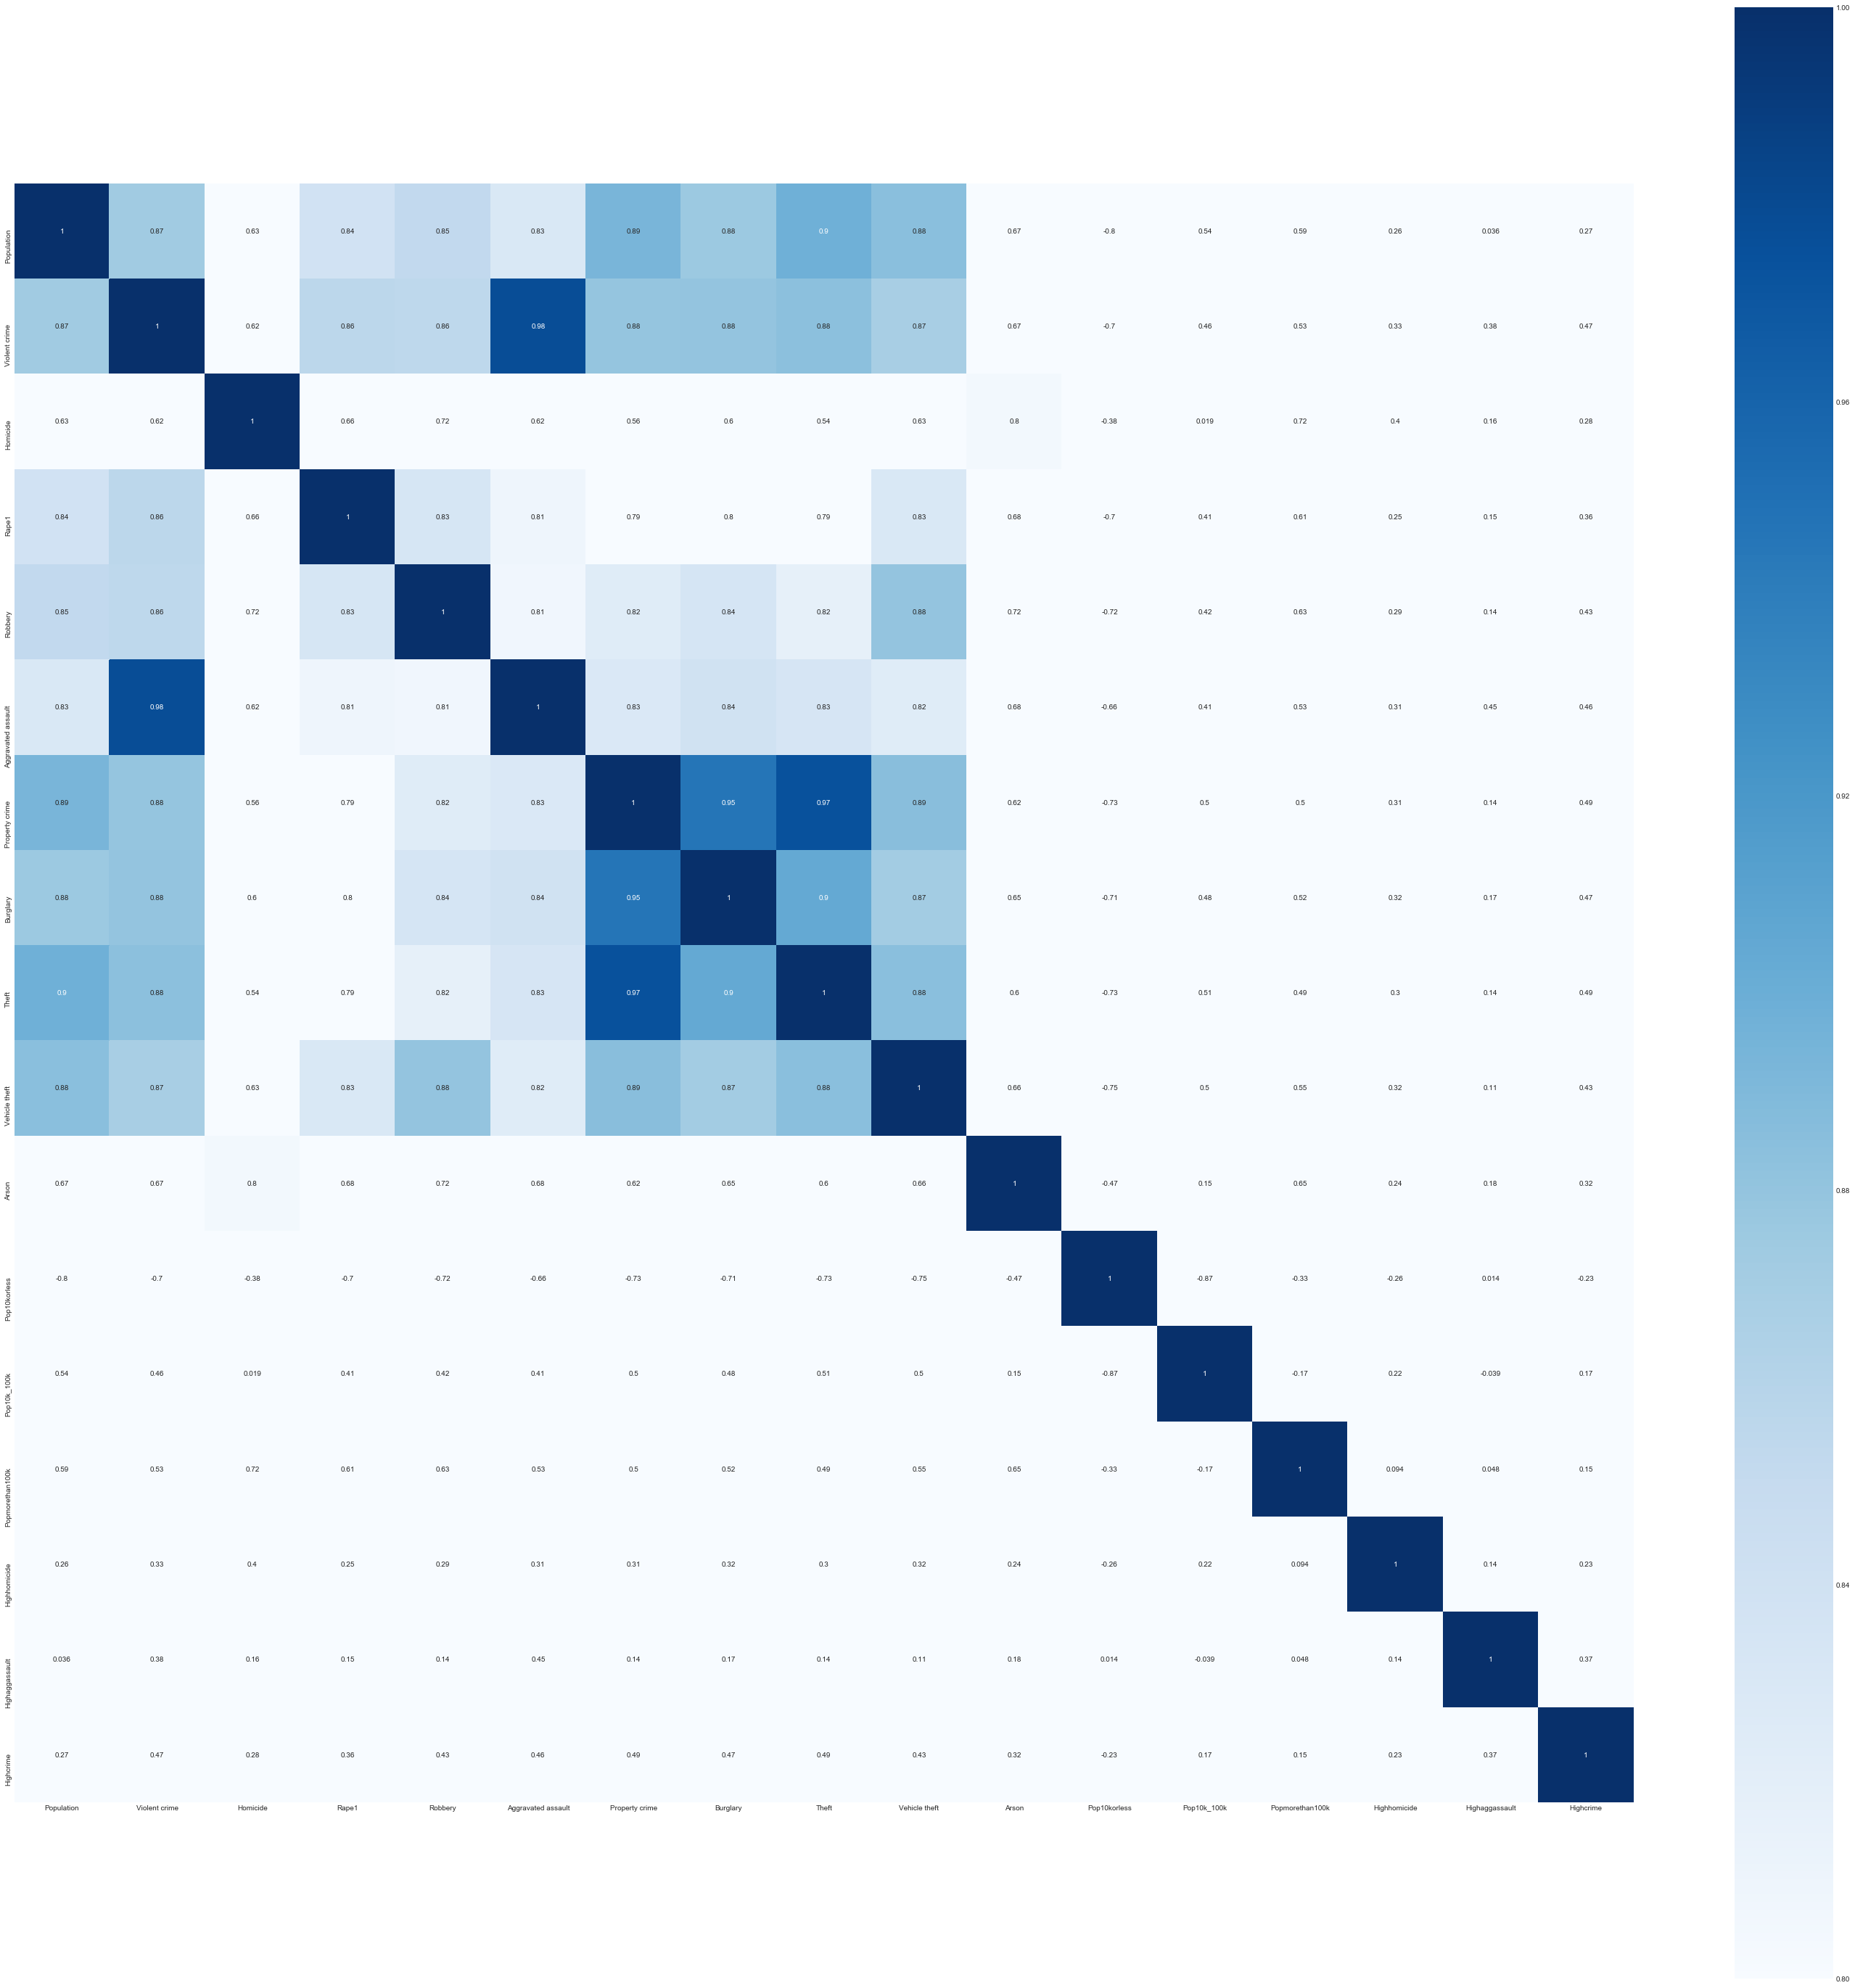

,Population,Violent crime,Homicide,Rape1,Robbery,Aggravated assault,Property crime,Burglary,Theft,Vehicle theft,Arson,Pop10korless,Pop10k_100k,Popmorethan100k,Highhomicide,Highaggassault,Highcrime
Population,1.000000,0.872985,0.625664,0.838585,0.852827,0.829971,0.893484,0.876532,0.898430,0.884510,0.669633,-0.804484,0.535529,0.591315,0.264660,0.036476,0.267768
Violent crime,0.872985,1.000000,0.621239,0.856427,0.855064,0.978089,0.879033,0.880093,0.883666,0.868852,0.670651,-0.702459,0.458415,0.534108,0.329483,0.379067,0.468465
Homicide,0.625664,0.621239,1.000000,0.663100,0.715234,0.620637,0.560667,0.603159,0.544416,0.631556,0.804793,-0.375501,0.019220,0.722112,0.396035,0.159449,0.283368
Rape1,0.838585,0.856427,0.663100,1.000000,0.833320,0.809056,0.788821,0.799049,0.792700,0.830458,0.683420,-0.696592,0.414583,0.606986,0.252394,0.154050,0.360528
Robbery,0.852827,0.855064,0.715234,0.833320,1.000000,0.807242,0.823614,0.835129,0.817518,0.880350,0.724494,-0.715697,0.422299,0.630702,0.285519,0.137522,0.433694
Aggravated assault,0.829971,0.978089,0.620637,0.809056,0.807242,1.000000,0.829411,0.839839,0.834122,0.823967,0.676937,-0.657332,0.414116,0.528507,0.308571,0.449668,0.458736
Property crime,0.893484,0.879033,0.560667,0.788821,0.823614,0.829411,1.000000,0.946462,0.974248,0.885768,0.616488,-0.727890,0.501076,0.503049,0.307621,0.140084,0.494560
Burglary,0.876532,0.880093,0.603159,0.799049,0.835129,0.839839,0.946462,1.000000,0.904131,0.872401,0.652202,-0.713874,0.475347,0.524454,0.318476,0.169569,0.473735
Theft,0.898430,0.883666,0.544416,0.792700,0.817518,0.834122,0.974248,0.904131,1.000000,0.884952,0.602480,-0.734871,0.513372,0.493393,0.298948,0.140127,0.494140
Vehicle theft,0.884510,0.868852,0.631556,0.830458,0.880350,0.823967,0.885768,0.872401,0.884952,1.000000,0.663554,-0.754168,0.501952,0.554491,0.315140,0.108506,0.427929


In [14]:
import seaborn as sns
crimedata.corr().unstack().sort_values().drop_duplicates()

corrmat = crimedata.corr()
print(corrmat)
# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(50, 50))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmin=.8, square=True, cmap="Blues", annot=True)
plt.show()
crimedata.corr()

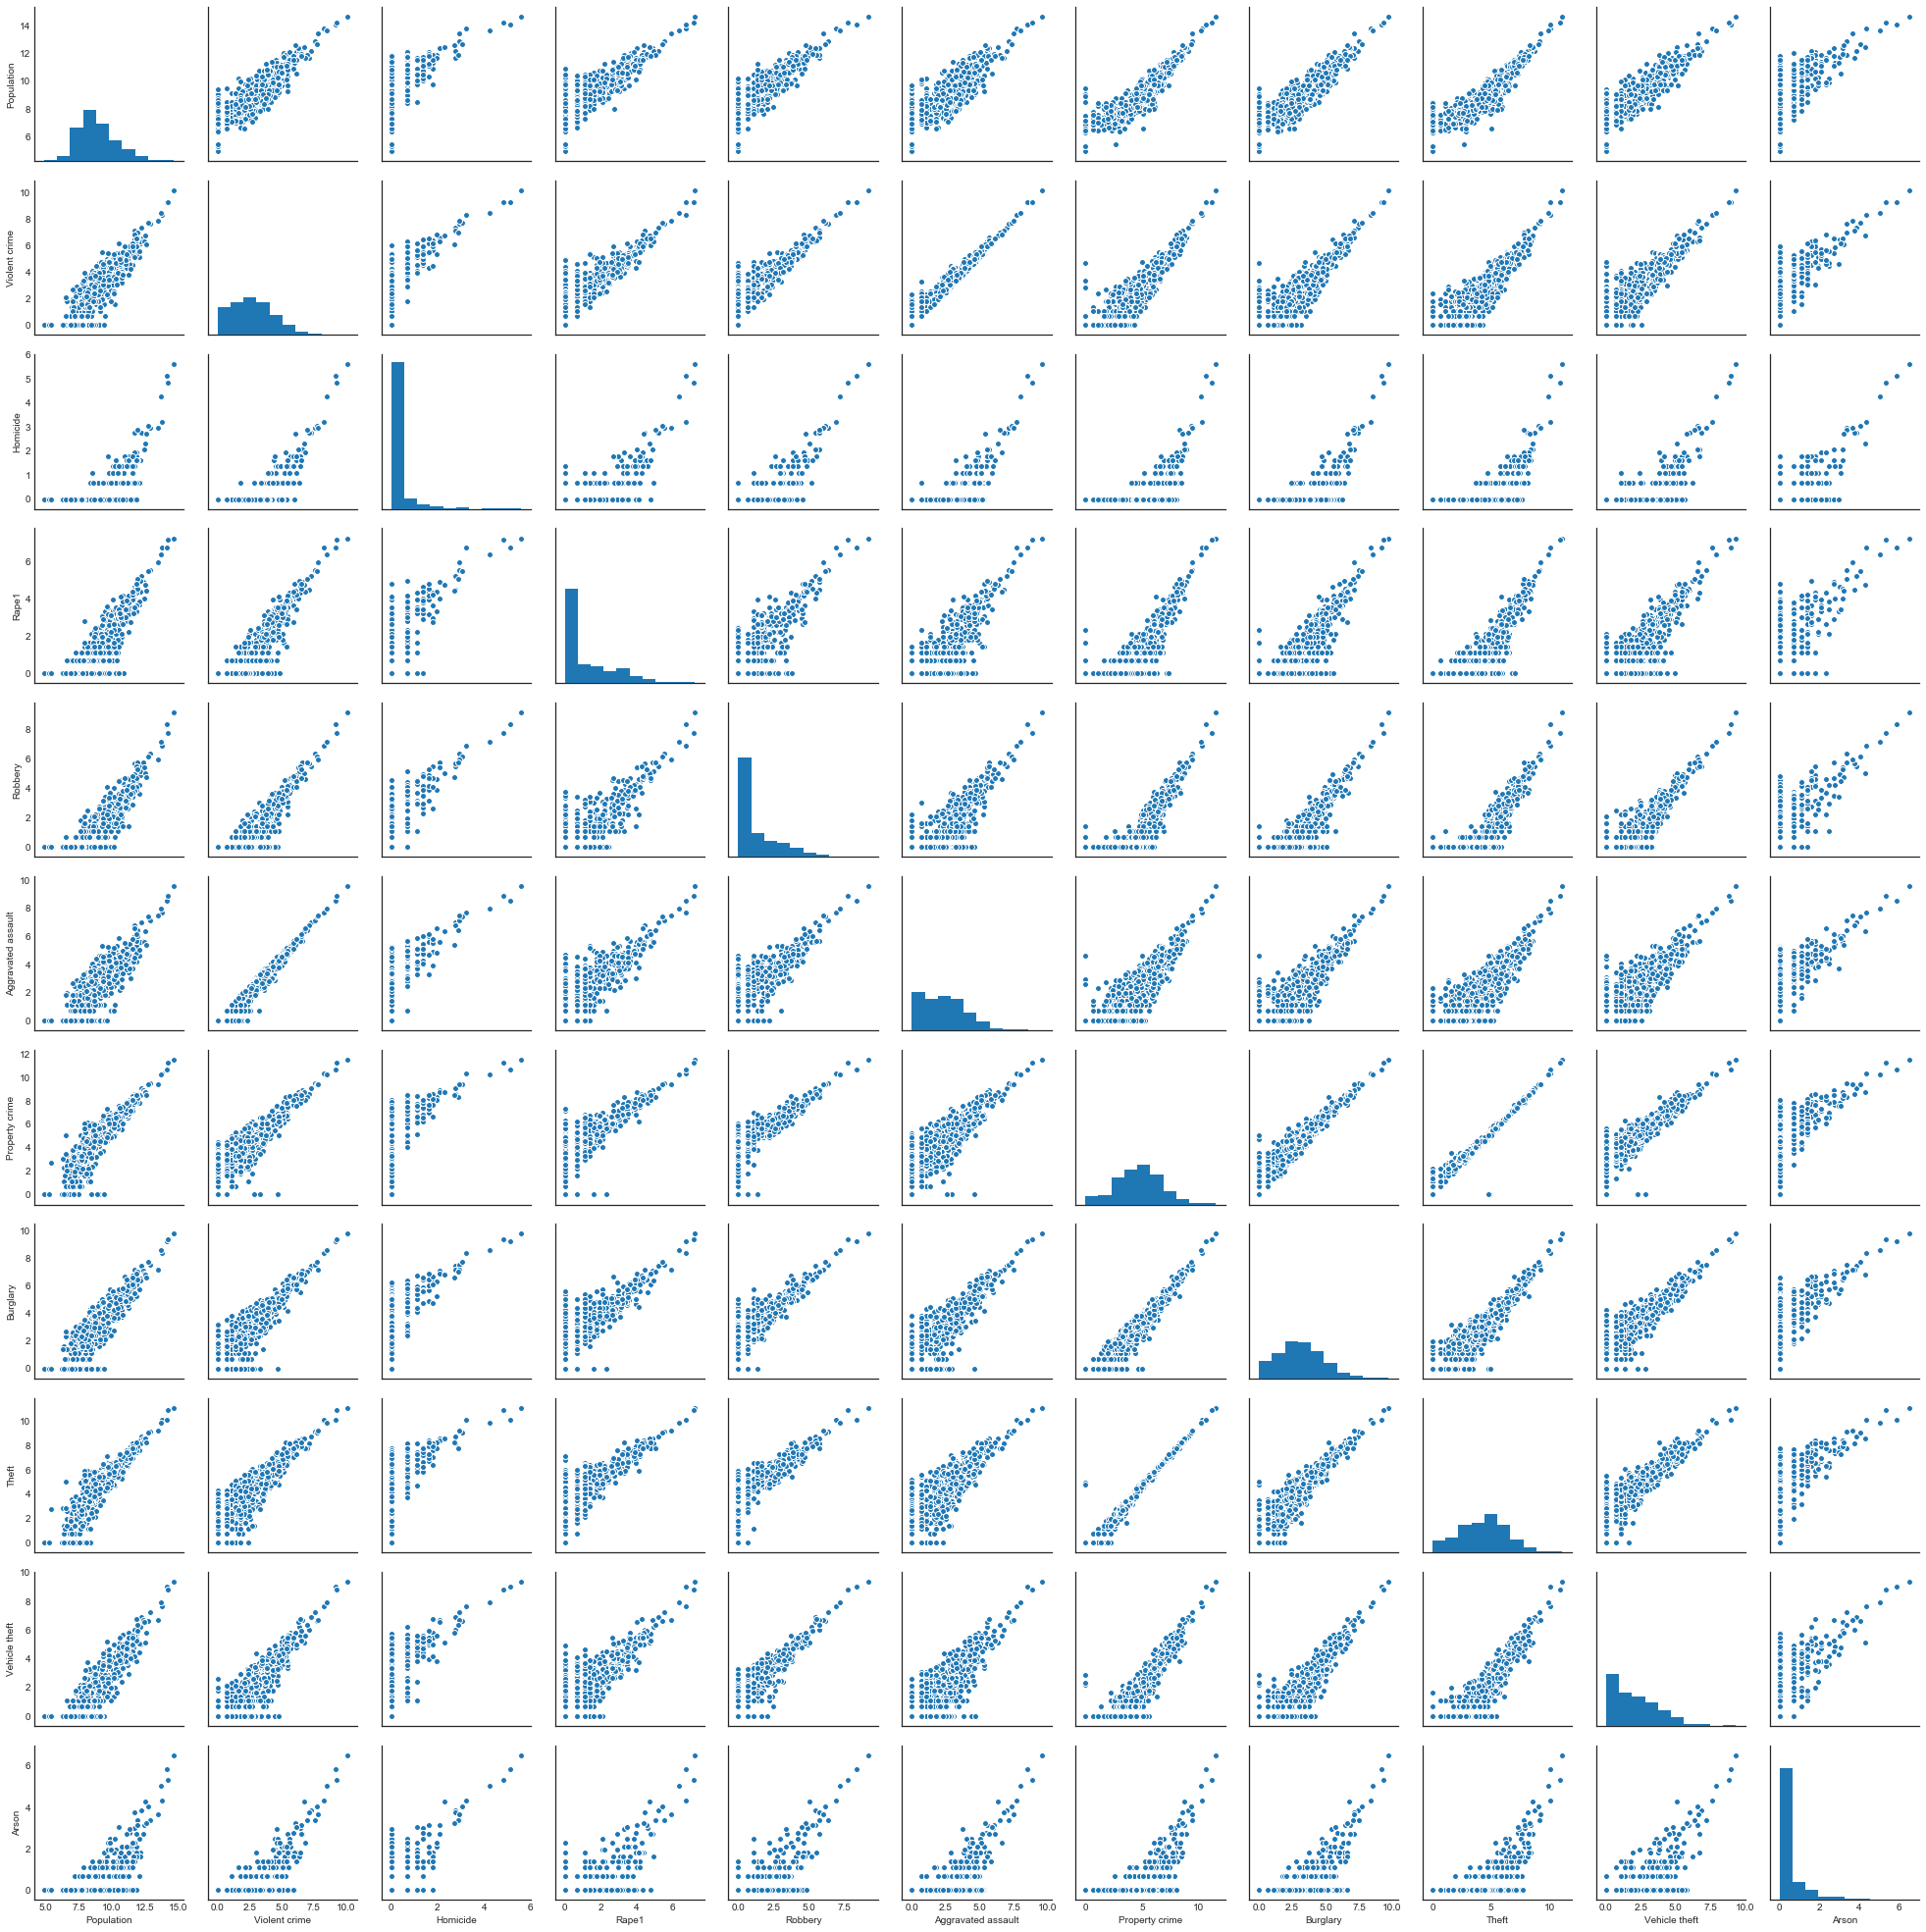

In [15]:
sns.pairplot(crimedata[features])

C:\Users\Martin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


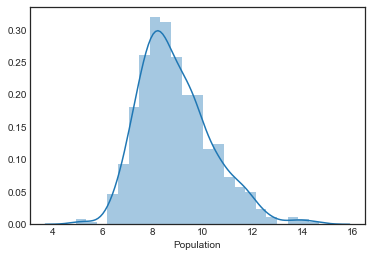

In [16]:
sns.distplot(crimedata.Population)

In [17]:
f = pd.DataFrame(crimedata.Population)

In [18]:
crimeoriglogfeatures = pd.DataFrame(crimedata[['Violent crime', 'Homicide', 'Rape1', 'Robbery', 'Aggravated assault', 'Property crime',
                                            'Vehicle theft', 'Arson', 'Burglary', 'Theft', 'Population']])

In [19]:
crimedata['Homicideboo'] = pd.Series(np.where(crimedata.Homicide > 0, 1, 0))
crimedata['Violentcrimeboo'] = pd.Series(np.where(crimedata['Violent crime'] > 0, 1, 0))
crimedata['Rape1boo'] = pd.Series(np.where(crimedata['Rape1'] > 0, 1, 0))
crimedata['Robberyboo'] = pd.Series(np.where(crimedata['Robbery'] > 0, 1, 0))
crimedata['Aggrassaultboo'] = pd.Series(np.where(crimedata['Aggravated assault'] > 0, 1, 0))
crimedata['Propcrimeboo'] = pd.Series(np.where(crimedata['Property crime'] > 0, 1, 0))
crimedata['Burglaryboo'] = pd.Series(np.where(crimedata['Burglary'] > 0, 1, 0))
crimedata['Theftboo'] = pd.Series(np.where(crimedata['Theft'] > 0, 1, 0))
crimedata['Vehtheftboo'] = pd.Series(np.where(crimedata['Vehicle theft'] > 0, 1, 0))
crimedata['Arsonboo'] = pd.Series(np.where(crimedata['Arson'] > 0, 1, 0))

In [20]:
f = pd.concat([f, crimedata.Homicideboo, crimedata.Violentcrimeboo, crimedata.Rape1boo, crimedata.Robberyboo,
              crimedata.Aggrassaultboo, crimedata.Propcrimeboo, crimedata.Burglaryboo, crimedata.Theftboo,
              crimedata.Vehtheftboo, crimedata.Arsonboo], axis=1)

In [21]:
boodata = f

In [22]:
boodata.head()

,Population,Homicideboo,Violentcrimeboo,Rape1boo,Robberyboo,Aggrassaultboo,Propcrimeboo,Burglaryboo,Theftboo,Vehtheftboo,Arsonboo
0,7.921536,0,1,0,0,1,1,1,1,1,0
1,11.719785,1,1,1,1,1,1,1,1,1,1
2,9.667449,0,1,1,1,1,1,1,1,1,1
3,9.870499,0,1,1,1,1,1,1,1,1,1
4,9.048645,0,1,0,0,1,1,1,1,1,0


In [23]:
print('# of cities reporting:' + str(len(crimedata.index)))

# of cities reporting:613


# Anaylyzing Data

C:\Users\Martin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


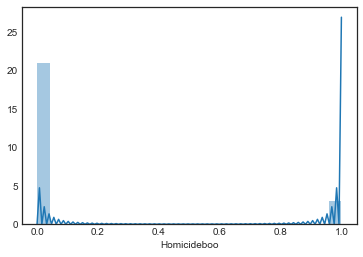

In [24]:
sns.distplot(f.Homicideboo)

C:\Users\Martin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


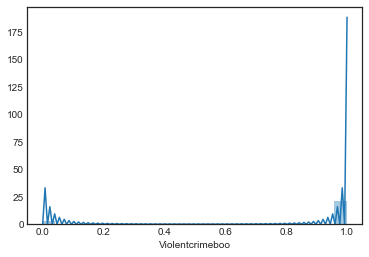

In [25]:
sns.distplot(crimedata.Violentcrimeboo)

                 Population  Homicideboo  Violentcrimeboo  Rape1boo  \
Population         1.000000     0.591706         0.389581  0.602776   
Homicideboo        0.591706     1.000000         0.133755  0.337167   
Violentcrimeboo    0.389581     0.133755         1.000000  0.364891   
Rape1boo           0.602776     0.337167         0.364891  1.000000   
Robberyboo         0.662020     0.358539         0.336294  0.483708   
Aggrassaultboo     0.423002     0.161477         0.828326  0.385902   
Propcrimeboo       0.202533     0.062509         0.336167  0.109085   
Burglaryboo        0.308659     0.107474         0.382525  0.230592   
Theftboo           0.284223     0.085087         0.389863  0.232121   
Vehtheftboo        0.518308     0.212536         0.444784  0.449179   
Arsonboo           0.589898     0.473180         0.185279  0.365551   

                 Robberyboo  Aggrassaultboo  Propcrimeboo  Burglaryboo  \
Population         0.662020        0.423002      0.202533     0.308659   

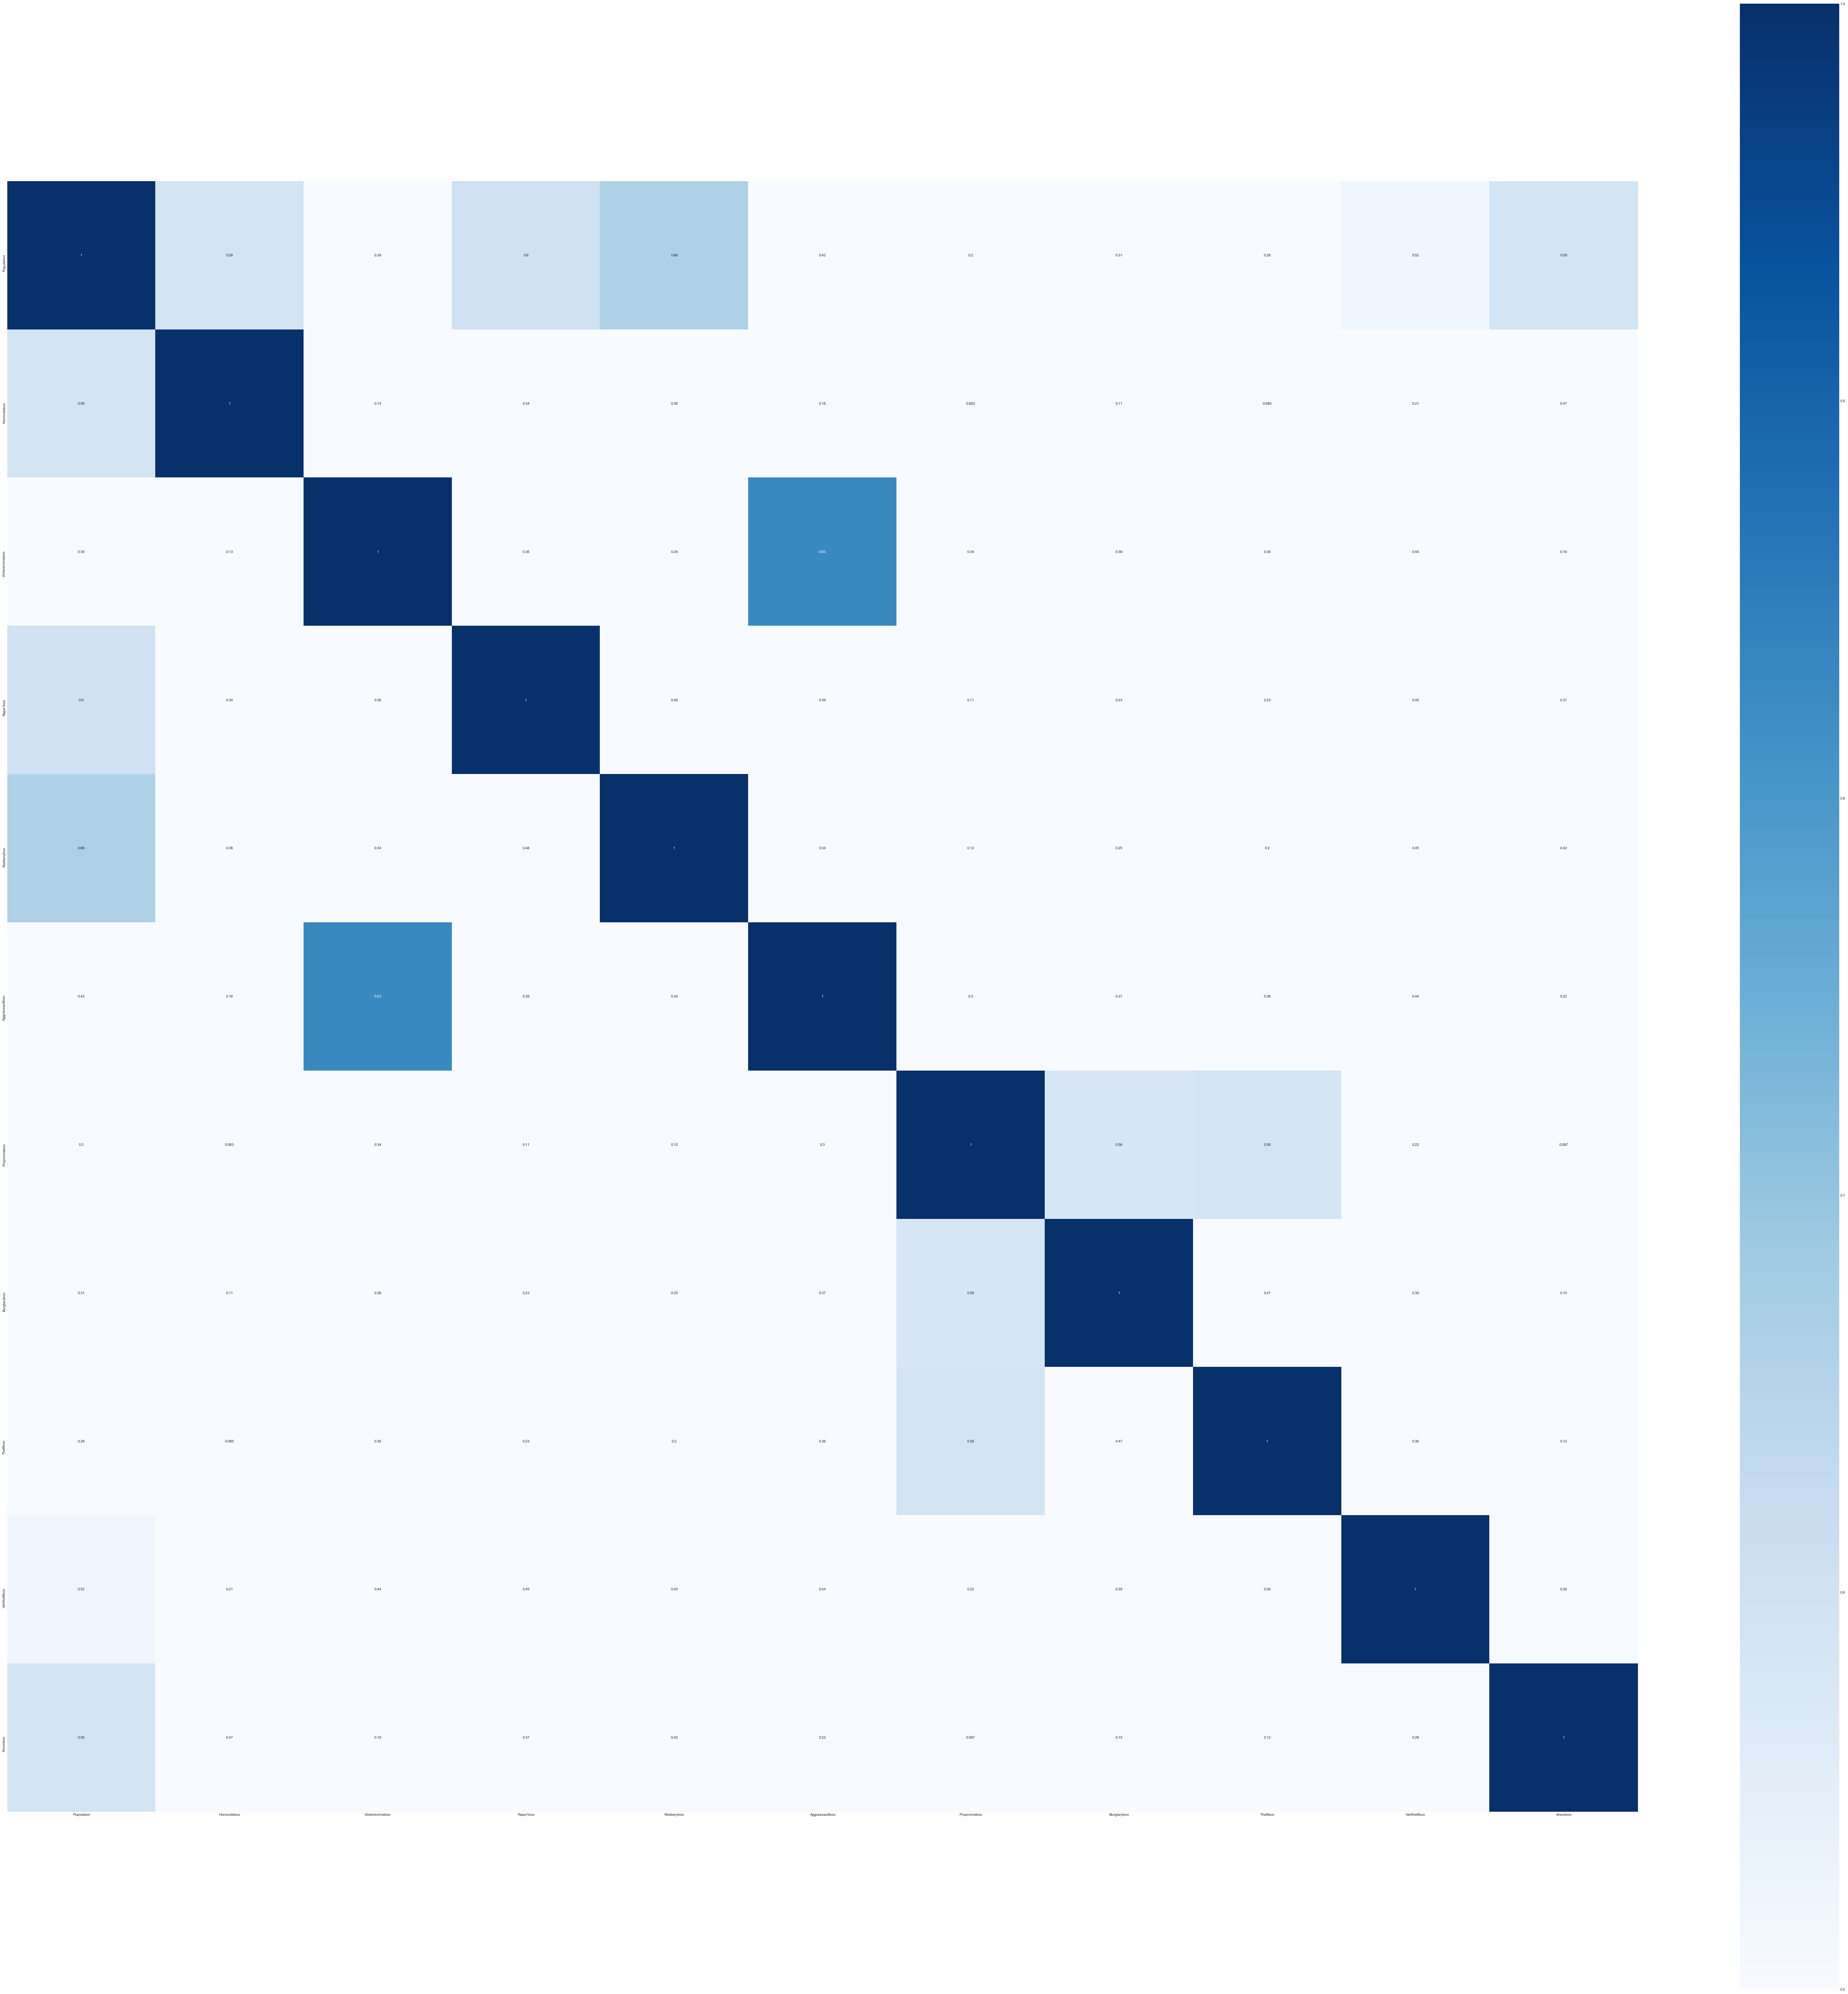

,Population,Homicideboo,Violentcrimeboo,Rape1boo,Robberyboo,Aggrassaultboo,Propcrimeboo,Burglaryboo,Theftboo,Vehtheftboo,Arsonboo
Population,1.000000,0.591706,0.389581,0.602776,0.662020,0.423002,0.202533,0.308659,0.284223,0.518308,0.589898
Homicideboo,0.591706,1.000000,0.133755,0.337167,0.358539,0.161477,0.062509,0.107474,0.085087,0.212536,0.473180
Violentcrimeboo,0.389581,0.133755,1.000000,0.364891,0.336294,0.828326,0.336167,0.382525,0.389863,0.444784,0.185279
Rape1boo,0.602776,0.337167,0.364891,1.000000,0.483708,0.385902,0.109085,0.230592,0.232121,0.449179,0.365551
Robberyboo,0.662020,0.358539,0.336294,0.483708,1.000000,0.342277,0.116202,0.245175,0.198549,0.449843,0.424530
Aggrassaultboo,0.423002,0.161477,0.828326,0.385902,0.342277,1.000000,0.301545,0.369163,0.355573,0.438744,0.223679
Propcrimeboo,0.202533,0.062509,0.336167,0.109085,0.116202,0.301545,1.000000,0.581622,0.590063,0.221880,0.086588
Burglaryboo,0.308659,0.107474,0.382525,0.230592,0.245175,0.369163,0.581622,1.000000,0.467608,0.387924,0.148873
Theftboo,0.284223,0.085087,0.389863,0.232121,0.198549,0.355573,0.590063,0.467608,1.000000,0.364178,0.117863
Vehtheftboo,0.518308,0.212536,0.444784,0.449179,0.449843,0.438744,0.221880,0.387924,0.364178,1.000000,0.275829


In [26]:
import seaborn as sns
boodata.corr().unstack().sort_values().drop_duplicates()

corrmat = boodata.corr()
print(corrmat)
# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(100, 100))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmin=.5, square=True, cmap="Blues", annot=True)
plt.show()
boodata.corr()

In [27]:
crimedata.head()


,City,Population,Violent crime,Homicide,Rape1,Robbery,Aggravated assault,Property crime,Burglary,Theft,...,Homicideboo,Violentcrimeboo,Rape1boo,Robberyboo,Aggrassaultboo,Propcrimeboo,Burglaryboo,Theftboo,Vehtheftboo,Arsonboo
0,Abernathy,7.921536,2.079442,0.000000,0.000000,0.000000,2.079442,3.295837,1.098612,2.772589,...,0,1,0,0,1,1,1,1,1,0
1,"Abilene2, 3",11.719785,6.455199,1.386294,4.605170,4.927254,5.976351,7.850104,5.497168,7.865188,...,1,1,1,1,1,1,1,1,1,1
2,Addison,9.667449,4.553877,0.000000,3.091042,2.772589,4.043051,6.650279,4.709530,6.336826,...,0,1,1,1,1,1,1,1,1,1
3,Alamo,9.870499,5.181784,0.000000,2.708050,2.995732,4.962845,6.852243,4.820282,6.647688,...,0,1,1,1,1,1,1,1,1,1
4,Alamo Heights,9.048645,2.639057,0.000000,0.000000,0.000000,2.564949,5.204007,3.218876,5.023881,...,0,1,0,0,1,1,1,1,1,0


In [28]:
crimedata.drop(['Violent crime', 'Homicide', 'Rape1', 'Robbery', 'Aggravated assault', 'Property crime', 
                'Violent crime', 'Vehicle theft', 'Arson', 'Burglary', 'Theft', 'City',], axis=1, inplace=True)

In [29]:
crimedata.head()

,Population,Pop10korless,Pop10k_100k,Popmorethan100k,Highhomicide,Highaggassault,Highcrime,Homicideboo,Violentcrimeboo,Rape1boo,Robberyboo,Aggrassaultboo,Propcrimeboo,Burglaryboo,Theftboo,Vehtheftboo,Arsonboo
0,7.921536,1,0,0,0,1,0,0,1,0,0,1,1,1,1,1,0
1,11.719785,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1
2,9.667449,0,1,0,0,1,1,0,1,1,1,1,1,1,1,1,1
3,9.870499,0,1,0,0,1,1,0,1,1,1,1,1,1,1,1,1
4,9.048645,1,0,0,0,0,0,0,1,0,0,1,1,1,1,1,0


                 Population  Pop10korless  Pop10k_100k  Popmorethan100k  \
Population         1.000000     -0.804484     0.535529         0.591315   
Pop10korless      -0.804484      1.000000    -0.873106        -0.333995   
Pop10k_100k        0.535529     -0.873106     1.000000        -0.167921   
Popmorethan100k    0.591315     -0.333995    -0.167921         1.000000   
Highhomicide       0.264660     -0.256141     0.219512         0.093528   
Highaggassault     0.036476      0.013771    -0.039468         0.048460   
Highcrime          0.267768     -0.233875     0.166211         0.151556   
Homicideboo        0.591706     -0.432018     0.129768         0.622662   
Violentcrimeboo    0.389581     -0.254964     0.220735         0.088783   
Rape1boo           0.602776     -0.558972     0.458756         0.243314   
Robberyboo         0.662020     -0.641262     0.534118         0.264004   
Aggrassaultboo     0.423002     -0.292585     0.250563         0.107184   
Propcrimeboo       0.2025

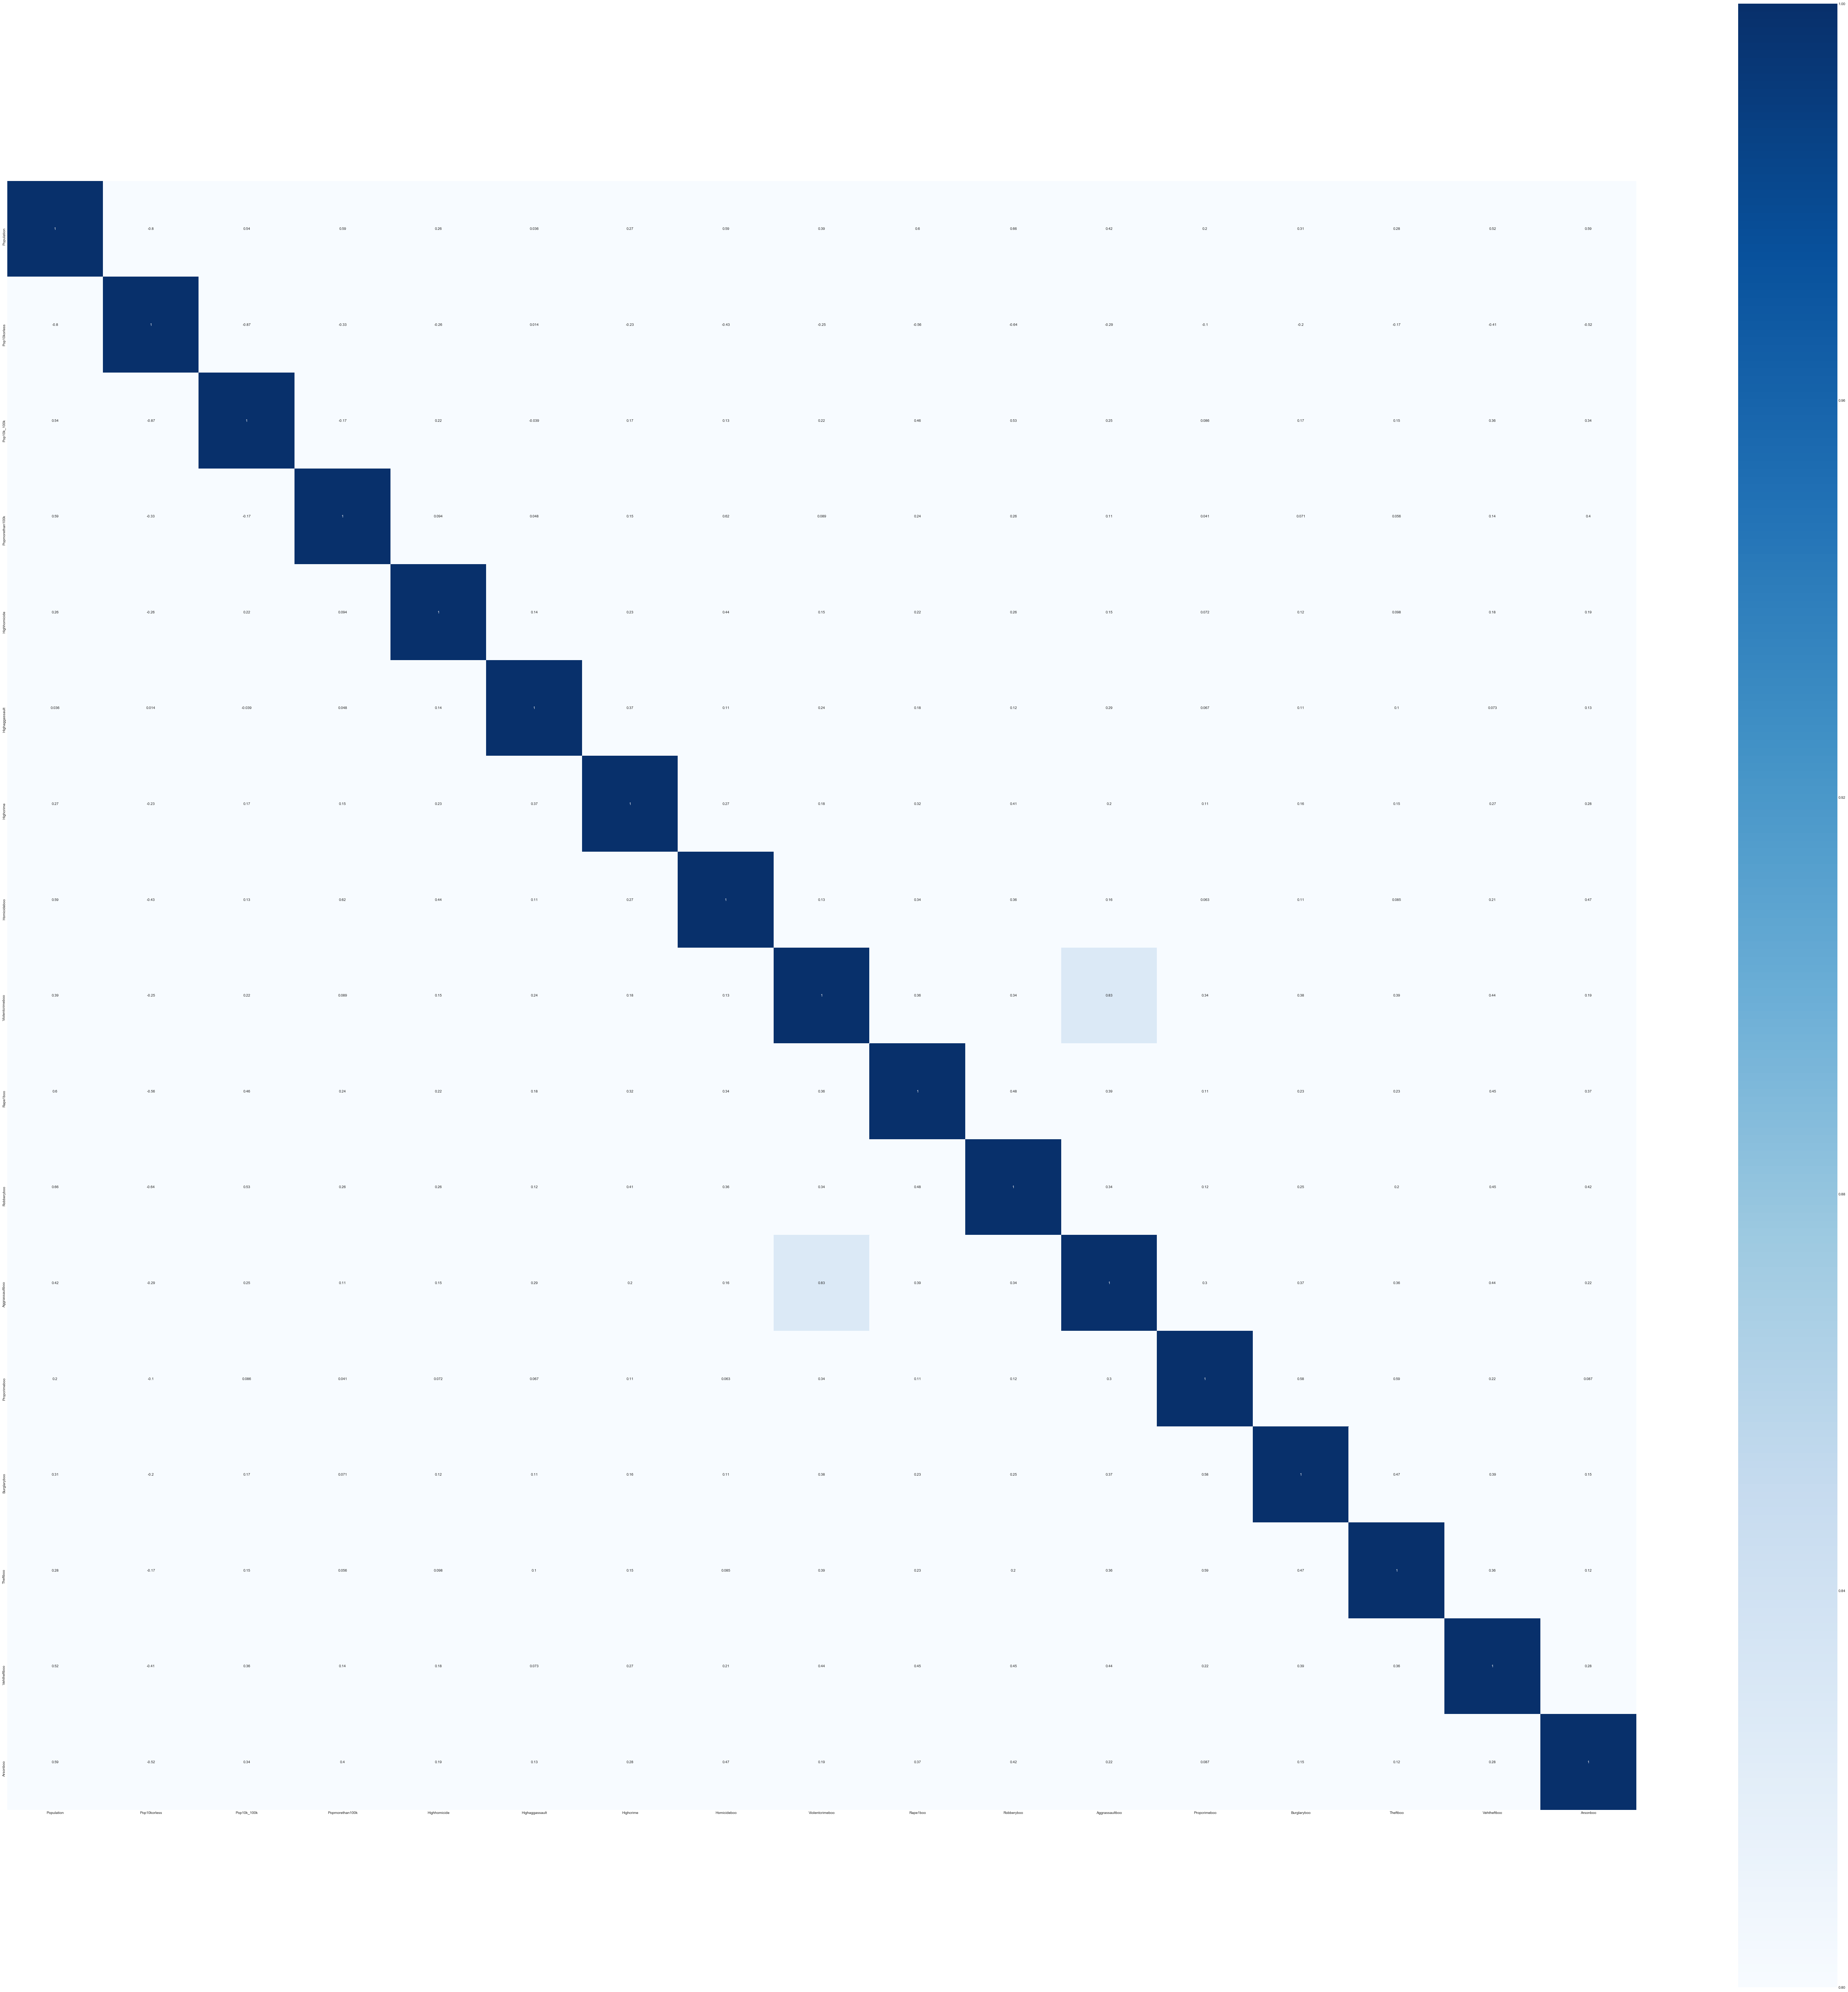

,Population,Pop10korless,Pop10k_100k,Popmorethan100k,Highhomicide,Highaggassault,Highcrime,Homicideboo,Violentcrimeboo,Rape1boo,Robberyboo,Aggrassaultboo,Propcrimeboo,Burglaryboo,Theftboo,Vehtheftboo,Arsonboo
Population,1.000000,-0.804484,0.535529,0.591315,0.264660,0.036476,0.267768,0.591706,0.389581,0.602776,0.662020,0.423002,0.202533,0.308659,0.284223,0.518308,0.589898
Pop10korless,-0.804484,1.000000,-0.873106,-0.333995,-0.256141,0.013771,-0.233875,-0.432018,-0.254964,-0.558972,-0.641262,-0.292585,-0.102981,-0.200601,-0.169099,-0.414415,-0.516676
Pop10k_100k,0.535529,-0.873106,1.000000,-0.167921,0.219512,-0.039468,0.166211,0.129768,0.220735,0.458756,0.534118,0.250563,0.086243,0.172902,0.147642,0.360451,0.335382
Popmorethan100k,0.591315,-0.333995,-0.167921,1.000000,0.093528,0.048460,0.151556,0.622662,0.088783,0.243314,0.264004,0.107184,0.041492,0.071338,0.056478,0.141075,0.396317
Highhomicide,0.264660,-0.256141,0.219512,0.093528,1.000000,0.139814,0.225596,0.444347,0.153737,0.217233,0.261933,0.148528,0.071847,0.123529,0.097798,0.181695,0.186193
Highaggassault,0.036476,0.013771,-0.039468,0.048460,0.139814,1.000000,0.374074,0.108565,0.238361,0.182849,0.119044,0.287762,0.067397,0.110835,0.102066,0.073367,0.132324
Highcrime,0.267768,-0.233875,0.166211,0.151556,0.225596,0.374074,1.000000,0.266443,0.182154,0.323264,0.413915,0.199768,0.111395,0.164628,0.151630,0.271455,0.276596
Homicideboo,0.591706,-0.432018,0.129768,0.622662,0.444347,0.108565,0.266443,1.000000,0.133755,0.337167,0.358539,0.161477,0.062509,0.107474,0.085087,0.212536,0.473180
Violentcrimeboo,0.389581,-0.254964,0.220735,0.088783,0.153737,0.238361,0.182154,0.133755,1.000000,0.364891,0.336294,0.828326,0.336167,0.382525,0.389863,0.444784,0.185279
Rape1boo,0.602776,-0.558972,0.458756,0.243314,0.217233,0.182849,0.323264,0.337167,0.364891,1.000000,0.483708,0.385902,0.109085,0.230592,0.232121,0.449179,0.365551


In [30]:
import seaborn as sns
crimedata.corr().unstack().sort_values().drop_duplicates()

corrmat = crimedata.corr()
print(corrmat)
# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(100, 100))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmin=.8, square=True, cmap="Blues", annot=True)
plt.show()
crimedata.corr()

In [31]:

#finalfeatures = ['Pop10korless','Pop10k_100k','Popmorethan100k','Highcrime','Homicideboo','Violentcrimeboo','Rape1boo',
 #                'Robberyboo','Aggrassaultboo','Propcrimeboo','Burglaryboo','Theftboo','Vehtheftboo','Arsonboo',]

#crimedata = crimedata[finalfeatures]



In [32]:
X = crimedata.drop(['Highcrime', 'Burglaryboo', 'Aggrassaultboo', 'Popmorethan100k', 'Highhomicide',
                   'Pop10korless', 'Pop10k_100k', 'Popmorethan100k'], axis=1)
y = crimedata['Highcrime']

In [33]:
crimedata.Highcrime.value_counts()

0    419
1    194
Name: Highcrime, dtype: int64

In [34]:
y.head()

0    0
1    0
2    1
3    1
4    0
Name: Highcrime, dtype: int32

In [35]:
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 10 columns):
Population         613 non-null float64
Highaggassault     613 non-null int32
Homicideboo        613 non-null int32
Violentcrimeboo    613 non-null int32
Rape1boo           613 non-null int32
Robberyboo         613 non-null int32
Propcrimeboo       613 non-null int32
Theftboo           613 non-null int32
Vehtheftboo        613 non-null int32
Arsonboo           613 non-null int32
dtypes: float64(1), int32(9)
memory usage: 26.4 KB


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.3, random_state=1)

In [37]:
logmodel = LogisticRegression()

In [38]:
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
prediction = logmodel.predict(X_test)

In [40]:
from sklearn.metrics import classification_report

In [41]:
classification_report(y_test, prediction)

'             precision    recall  f1-score   support\n\n          0       0.84      0.92      0.88       128\n          1       0.77      0.59      0.67        56\n\navg / total       0.82      0.82      0.81       184\n'

In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
confusion_matrix(y_test, prediction)

array([[118,  10],
       [ 23,  33]], dtype=int64)

In [44]:
from sklearn.metrics import accuracy_score

In [45]:
accuracy_score(y_test, prediction)

0.8206521739130435

# Ridge Regression begins here.

In [46]:
ridgeregr = linear_model.Ridge(alpha=1, fit_intercept=False) 
ridgeregr.fit(X_train, y_train)
print(ridgeregr.score(X_train, y_train))
origparams = ridgeregr.coef_[0]
print(origparams)



0.2904948662363308
-0.031021326693899207


In [47]:
'''
from sklearn.feature_selection import RFE

selector = RFE(logmodel)
selector = selector.fit(X_train, y_train)
'''

'\nfrom sklearn.feature_selection import RFE\n\nselector = RFE(logmodel)\nselector = selector.fit(X_train, y_train)\n'

In [48]:
from sklearn.model_selection import cross_val_score
cross_val_score(ridgeregr, X, y, cv=10)

array([0.45997269, 0.13251038, 0.10477804, 0.36855263, 0.4103399 ,
       0.21771892, 0.34045374, 0.14423027, 0.36223701, 0.32037806])

In [49]:
#rankings = pd.DataFrame({'Features': X.columns, 'Ranking' : selector.ranking_})
#rankings.sort_values('Ranking')

# Lasso Regression begins here.

In [50]:
lass = linear_model.Lasso(alpha=.01)
lassfit = lass.fit(X_train, y_train)
print('R² for the model with few features:')
print(lass.score(X_train, y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)


R² for the model with few features:
0.263866089640297

Parameter estimates for the model with few features:
[-0.          0.27557441  0.         -0.          0.08639064  0.21558057
  0.          0.          0.0413995   0.03784082  0.04805873]


In [51]:
from sklearn.model_selection import cross_val_score
cross_val_score(lass, X, y, cv=10)

array([0.42117174, 0.12979754, 0.12074018, 0.30934766, 0.37370469,
       0.19276518, 0.36291401, 0.13975713, 0.32763417, 0.29338074])

# Rergression analysis with log transformed data, but no boolean features.

In [52]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import scipy
from scipy.stats import spearmanr
from pylab import rcParams
import seaborn as sb
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
%matplotlib inline
sns.set_style('white')

crimedata = pd.read_csv('texas2017crime.csv')

crimedata.rename(columns={'State' : 'City', 'Murder and\nnonnegligent\nmanslaughter': 'Homicide', 'Violent\ncrime' : 'Violent crime',
                         'Aggravated\nassault' : 'Aggravated assault','Motor\nvehicle\ntheft' :  'Vehicle theft',
                         'Larceny-\ntheft' : 'Theft', 'Property\ncrime' : 'Property crime' }, inplace = True)



In [53]:
features = list(crimedata.columns)
features.pop(0)

'City'

In [54]:
crimedata['Population'] = crimedata['Population'].replace({',':''}, regex=True)
#crimedata['Homicide'] = crimedata['Homicide'].replace({',':''}, regex=True)
crimedata['Aggravated assault'] = crimedata['Aggravated assault'].replace({',':''}, regex=True)
crimedata['Violent crime'] = crimedata['Violent crime'].replace({',':''}, regex=True)
crimedata['Vehicle theft'] = crimedata['Vehicle theft'].replace({',':''}, regex=True)
crimedata['Theft'] = crimedata['Theft'].replace({',':''}, regex=True)
crimedata['Property crime'] = crimedata['Property crime'].replace({',':''}, regex=True)
crimedata['Rape1'] = crimedata['Rape1'].replace({',':''}, regex=True)
crimedata['Robbery'] = crimedata['Robbery'].replace({',':''}, regex=True)
crimedata['Burglary'] = crimedata['Burglary'].replace({',':''}, regex=True)





In [55]:
crimedata['Population'] = crimedata['Population'].astype('int64')
crimedata['Property crime'] = crimedata['Property crime'].astype('float64')
crimedata['Burglary'] = crimedata['Burglary'].astype('float64')
crimedata['Theft'] = crimedata['Theft'].astype('float64')
crimedata['Vehicle theft'] = crimedata['Vehicle theft'].astype('int64')
crimedata['Arson'] = crimedata['Arson'].astype('int64')
crimedata['Rape1'] = crimedata['Rape1'].astype('int64')
crimedata['Robbery'] = crimedata['Robbery'].astype('int64')
crimedata['Aggravated assault'] = crimedata['Aggravated assault'].astype('int64')
crimedata['Violent crime'] = crimedata['Violent crime'].astype('int64')



In [56]:
crimedata[features] = crimedata[features].replace(np.nan, 0)

In [57]:
citycrimerate = []
for i, row in crimedata.iterrows():
    i = ((crimedata['Violent crime'] + crimedata['Property crime']) / crimedata['Population']) * 100000
    citycrimerate.append(i)
xray = pd.Series(citycrimerate[1])
crimedata['citycrimerate'] = xray

   




In [58]:
crimedata.head()

,City,Population,Violent crime,Homicide,Rape1,Robbery,Aggravated assault,Property crime,Burglary,Theft,Vehicle theft,Arson,citycrimerate
0,Abernathy,2756,8,0,0,0,8,27.0,3.0,16.0,8,0,1269.956459
1,"Abilene2, 3",122981,636,4,100,138,394,2566.0,244.0,2605.0,260,20,2603.654223
2,Addison,15795,95,0,22,16,57,773.0,111.0,565.0,97,5,5495.409940
3,Alamo,19351,178,0,15,20,143,946.0,124.0,771.0,51,2,5808.485350
4,Alamo Heights,8507,14,0,0,1,13,182.0,25.0,152.0,5,0,2303.984954


In [59]:
crimedata['citycrimerate'] = np.log(crimedata['citycrimerate'].replace(0, np.nan))


In [60]:
crimedata.head()

,City,Population,Violent crime,Homicide,Rape1,Robbery,Aggravated assault,Property crime,Burglary,Theft,Vehicle theft,Arson,citycrimerate
0,Abernathy,2756,8,0,0,0,8,27.0,3.0,16.0,8,0,7.146738
1,"Abilene2, 3",122981,636,4,100,138,394,2566.0,244.0,2605.0,260,20,7.864671
2,Addison,15795,95,0,22,16,57,773.0,111.0,565.0,97,5,8.611668
3,Alamo,19351,178,0,15,20,143,946.0,124.0,771.0,51,2,8.667075
4,Alamo Heights,8507,14,0,0,1,13,182.0,25.0,152.0,5,0,7.742395


In [61]:

crimedata[features] = np.log(crimedata[features].replace(0, np.nan))

crimedata['Highcrime'] = pd.Series(np.where(crimedata['citycrimerate'] > 7.91, 1, 0))



In [62]:
crimedata[features] = crimedata[features].replace(np.nan, 0)

In [63]:
crimedata = crimedata.replace(np.nan, 0)

In [64]:
features

['Population',
 'Violent crime',
 'Homicide',
 'Rape1',
 'Robbery',
 'Aggravated assault',
 'Property crime',
 'Burglary',
 'Theft',
 'Vehicle theft',
 'Arson']

In [65]:
crimedata.Highcrime.value_counts()

0    416
1    197
Name: Highcrime, dtype: int64

In [66]:
X = crimedata.drop(['City','Highcrime', 'Violent crime', 'Property crime'], axis=1)
y = crimedata['Highcrime']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.3, random_state=1)

In [68]:
logmodel = LogisticRegression()

In [69]:
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
y.head()

0    0
1    0
2    1
3    1
4    0
Name: Highcrime, dtype: int32

In [71]:
X.head()

,Population,Homicide,Rape1,Robbery,Aggravated assault,Burglary,Theft,Vehicle theft,Arson,citycrimerate
0,7.921536,0.000000,0.000000,0.000000,2.079442,1.098612,2.772589,2.079442,0.000000,7.146738
1,11.719785,1.386294,4.605170,4.927254,5.976351,5.497168,7.865188,5.560682,2.995732,7.864671
2,9.667449,0.000000,3.091042,2.772589,4.043051,4.709530,6.336826,4.574711,1.609438,8.611668
3,9.870499,0.000000,2.708050,2.995732,4.962845,4.820282,6.647688,3.931826,0.693147,8.667075
4,9.048645,0.000000,0.000000,0.000000,2.564949,3.218876,5.023881,1.609438,0.000000,7.742395


In [72]:
prediction = logmodel.predict(X_test)

In [73]:
from sklearn.metrics import classification_report
classification_report(y_test, prediction)

'             precision    recall  f1-score   support\n\n          0       0.99      0.98      0.99       128\n          1       0.96      0.98      0.97        56\n\navg / total       0.98      0.98      0.98       184\n'

In [74]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, prediction)

array([[126,   2],
       [  1,  55]], dtype=int64)

In [75]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, prediction)

0.9836956521739131

In [76]:
from sklearn.model_selection import cross_val_score
cross_val_score(logmodel, X, y, cv=10)

array([0.93548387, 0.9516129 , 0.96774194, 0.98387097, 1.        ,
       0.96774194, 0.91803279, 0.98333333, 1.        , 1.        ])

In [77]:
y.value_counts()

0    416
1    197
Name: Highcrime, dtype: int64

# Ridge Rergression analysis with log transformed data, but no boolean features.

In [78]:
ridgeregr = linear_model.Ridge(alpha=1, fit_intercept=False) 
ridgeregr.fit(X_train, y_train)
print(ridgeregr.score(X_train, y_train))
origparams = ridgeregr.coef_[0]
print(origparams)



0.4469452044090003
-0.158081466653477


In [79]:
from sklearn.model_selection import cross_val_score
cross_val_score(ridgeregr, X, y, cv=10)

array([0.52225931, 0.30422202, 0.22517455, 0.45600906, 0.45898284,
       0.42259304, 0.27434468, 0.27221475, 0.49365611, 0.56416489])

# Lasso Rergression analysis with log transformed data, but no boolean features.

In [80]:
lass = linear_model.Lasso(alpha=.01)
lassfit = lass.fit(X_train, y_train)
print('R² for the model with few features:')
print(lass.score(X_train, y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)


R² for the model with few features:
0.5082809988988715

Parameter estimates for the model with few features:
[-0.35126247  0.          0.          0.07909605  0.06656409  0.07386341
  0.1726826   0.          0.          0.02080614  2.06725434]


In [81]:
from sklearn.model_selection import cross_val_score
cross_val_score(lass, X, y, cv=10)

array([0.56822383, 0.41194062, 0.34146736, 0.5506614 , 0.51862396,
       0.51190776, 0.49433442, 0.35201174, 0.58722486, 0.60671903])